# Nutrient Model
This project is adapted from a "Superproblem" in _Tracers in the Sea_ by Broecker and Peng (1982). The learning goals are as follows:
- Understand the purpose and high-level procedure of modeling
- Translate between physical, mathematical, programmatic, and graphical representations 
- Interpret, evaluate, and communicate model predictions in a real-world context
- Explain broad patterns in marine chemistry in terms of physical and biogeochemical factors

As modelers, we start with a question: _how do physical circulation and biogeochemistry shape nutrient abundances in the global ocean?_ It is nearly impossible to answer a question of this scale and complexity through direct observation of the ocean, much less controlled experimentation. Instead, we can turn to modeling. The idea is to identify the most important elements of the real thing we want to study and reproduce them to the best of our ability in a simplified, controlled environment. This approach makes direct observation much easier, and we can perform well-controlled _experiments._ However, we need to be very careful in choosing _which_ elements to include in our model, and _how_ to include them.

Here, most of this preliminary work has been done already. We are modeling a hypothetical apparatus of four interconnected tanks as our highly simplified analog of the global ocean, as shown below. The left column is the Indian & Pacific; the right is the Atlantic. Each ocean basin has a small surface tank and a large deep tank. In the real world, these are meant to capture the distinct biogeochemical character of the sunlit surface and darker depth. The number on each tank is its volume in liters. Black arrows represent pumps between tanks, labeled with flow rates in liters per hour. These pumps represent the physical circulation of ocean currents. Notice the asymmetry: for example, _all_ deepwater formation occurs in the Atlantic basin. 

Biogeochemical cycling is a bit more complicated, and we will need some creativity in how exactly we define it. But the key idea is the downward transport of nutrients (green arrows).

<img src="diagram.png" width=500 />

What follows is a systematic translation of this physical system into mathematical and programmatic representations. If this material is unfamiliar, feel free to start by exploring the graphs, which are always preceded immediately by the code which produced them. Always try to interpret what you see in terms of the real ocean, or at least the physical model of interconnected tanks. You are not required to reproduce any of the code or mathematics, it is only presented


## Model Setup: Single Tank
We're interested in predicting the how the nutrient concentrations of each tank will evolve through time. Let's start with a simpler example to see how to program this model and implement it in python. Imagine a single tank, with one input and one output. To keep things simple, we will assume the volumetric flow rate in and out are equal, so the tank volume doesn't change. But we're not really interested in the volume; we're interested in the concentration of dissolved phosphate in the tank. Assuming we know what the concentration is at some moment, we want to predict how it is changing. Let's call the concentration in the tank $c$, and the rate at which it is changing: $c'.$ If we can design an expression which solves $c'$ for any input $c$, we can predict the evolution of the system over time. This ability to transform information about rates at a single moment into states way into the future is the realm of differential equations, an extremely important application of calculus in science. Here's what that transformation looks like mathematically:

$$c'=f(c)\longrightarrow c = g(t)$$

Again, the point of performing this transformation is that ultimately we want to be able to choose some time $t$ in the future and predict $c$. But we have to start with the information at hand, and the best we can do there is to express $c'$ in terms of $c$. Now, let's begin actually designing our system.  Finding an expression for $c'=f(c)$ turns out to be a bit harder than it looks, since $c$ is a ratio of moles (amount) to volume. It will be easier to start with simply asking how much nutrient (in moles) is in our tank, and how much is that amount changing? You should convince yourself that the amount of nutrient in a tank is the concentration (moles/L) times the volume (L). So let's express volume as $v$ and start our equation with the term $vc'$ instead of $c'$. And how is $vc$ changing; that is, what is $vc'$? We will have to consider the balance of nutrient entering and exiting the tank. Now again, we can't just consider the concentration of solution flowing in and out, we have to consider each amount flux (mol/hr) as a product of volumetric flow rate (L/hr) and concentration (mol/L). The inflow serves to increase the amount of nutrient in the tank, and the outflow decreases the amount:

$$vc'=q_\text{in}c_\text{in} - q_\text{out}c_\text{out}.$$

That's really the heart of our model! There are a few adjustments we will want to make before we generalize this to our full system of four tanks. First, we should recognize that the concentration of water flowing out of the tank $(c_\text{out})$ should be equal to the concentration in the tank itself $(c)$. Similarly, if we were to imagine the inflow coming from some other tank, $c_\text{in}$ would be equal to the concentration of _that_ tank. And second, we will divide both sides of the equation by $v$ to solve for $c'$ as we were hoping for:

$$\boxed{c'=f(c) = (q_\text{in}c_\text{in} - q_\text{out}c)/v.}$$

That's it! Let's implement this simplified model and see if we can interpret the behavior. Don't worry if the code below doesn't make sense yet, start by interpreting the plot in terms of physical changes in the tank. Click anywhere in the cell below and press Shift-Enter to run.

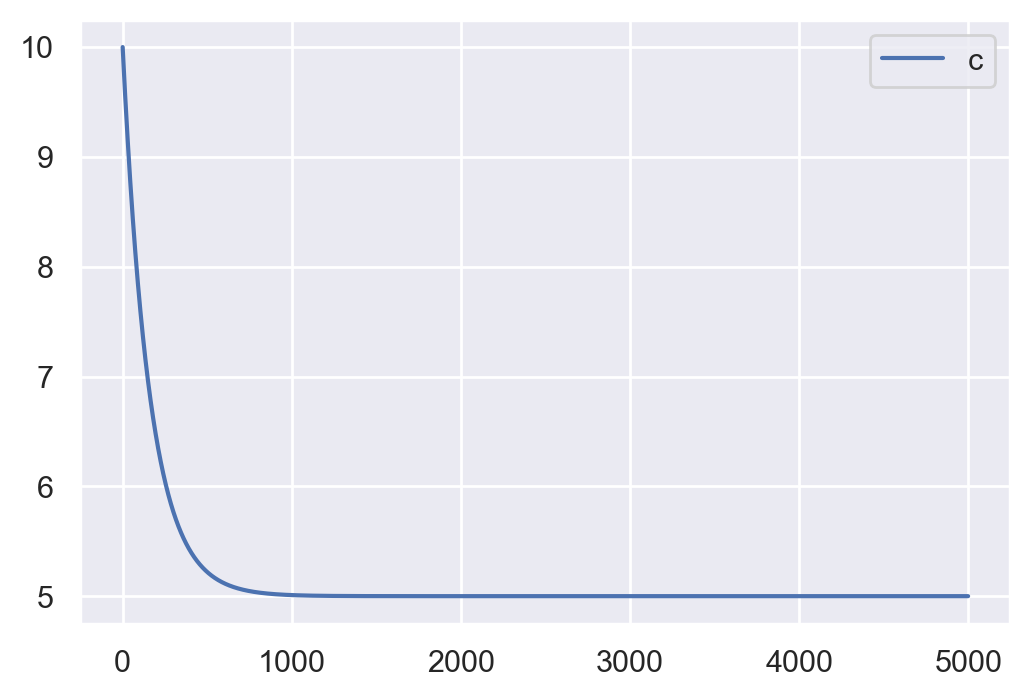

In [50]:
import numpy as np # computing
from scipy.integrate import odeint # ordinary differential equations
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots

# - - - - - - - - - - - - - - - - - - - - - - - - - 

# define parameters: volumes, flow rates, steady inflow concentration
q_in = q_out = 0.5 # L/hr
c_in = 5 # umol/L
vol = 80 # using "vol" here for volume so we can save "v" for later

# - - - - - - - - - - - - - - - - - - - - - - - - - 

# define system for one tank (just one equation)
def sys_one(c, t): # a function of c (could also depend on time)
    return (q_in * c_in - q_out * c) / vol # compute c' = f(c)

# - - - - - - - - - - - - - - - - - - - - - - - - - 

# set initial condition: concentration at t = 0
c_0 = 10 # umol/L

# time interval: array of integers from 0 to 5000
t = np.arange(5000) # hr

# - - - - - - - - - - - - - - - - - - - - - - - - - 

# solve initial value problem
sol_one = odeint(sys_one, c_0, t)

# - - - - - - - - - - - - - - - - - - - - - - - - - 

# plot settings
sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})

# plot solution
sns.lineplot(data=sol_one)
plt.legend(labels="c")

Experiment with adjusting parameters, initial conditions and time intervals! In particular, make sure you understand what conditions lead to increasing vs. decreasing concentration. If the system's behavior doesn't match your expectations, be sure to discuss and ask questions before proceeding. And when you've finished experimenting, reset $t$ to 5000 hrs.

## Full Model Setup
Now, we are interested in predicting the concentrations of all four interconnected tanks. With this added complexity, we want to think carefully about how to organize all the components of our system. First, when ordered lists are built in python, we always start counting with 0. For consistency, we will always list our tanks A through D, with indices 0 through 3. So instead of a single volume $v$, we will indicate a list of volumes $\mathbf{v}$ in bold. These lists are also called "vectors." Subscripts will represent index; $\mathbf{v}_0$ is the volume of tank A, etc. Similarly, we will need a list of concentrations $\mathbf{c}$, and we will want to solve for $\mathbf{c}'$. Our new roadmap is very familiar:
$$\mathbf{c}'=f(\mathbf{c})\longrightarrow\mathbf{c} = g(t)$$
Let's start with considering a single tank, and see how the situation differs from that above. We want to be especially careful in how we define our volumetric flows; clearly, "in" and "out" will not suffice. As with our concentrations and volumes, we can use the indices 0 through 3 to represent tanks, but notice for flows we need _two_ indices, since each flow represents a relationship between two tanks. And the ordered of those indices matters; flow from tank A to B is not the same as from B to A! We can still use the letter $q$, but we'll set the first index as the sink and the second index as the source. In other words, $q_{ij}$ is the flow rate from tank $j$ to tank $i$: $q_{32}$ is from C to D, etc. Let's look at an equation for just one of the tanks, A. As before, the left side will be the relevant volume times the change in concentration: $\mathbf{v}_0\mathbf{c}'_0.$ And on the right, we'll want to account for all the inflows and (negative) outflows, each multiplied by the concentration of their source:

$$q_{01}\mathbf{c}_1 + q_{02}\mathbf{c}_2 + q_{03}\mathbf{c}_3-q_{10}\mathbf{c}_0-q_{20}\mathbf{c}_0-q_{30}\mathbf{c}_0$$

As we put the left and right together, we can collect like terms: all the outflows have the same concentration $(\mathbf{c}_0)$. We will find it convenient to rearrange so all the $\mathbf{c}$ terms are listed in order of their indices:

$$\mathbf{v}_0\mathbf{c}'_0 = \mathbf{c}_0(-q_{10}-q_{20}-q_{30}) + \mathbf{c}_1q_{01} + \mathbf{c}_2q_{02} + \mathbf{c}_3q_{03}$$

We can repeat this process for the other three tanks, and hopefully begin to see some patterns emerging:

$$\begin{gather*}
	\mathbf{v}_0\mathbf{c}'_0= 
	\mathbf{c}_0(-q_{10}-q_{20}-q_{30}) + \mathbf{c}_1q_{01} + \mathbf{c}_2q_{02} + \mathbf{c}_3q_{03}\\
	\mathbf{v}_1\mathbf{c}'_1= 
	\mathbf{c}_0q_{10} + \mathbf{c}_1(-q_{01}-q_{21}-q_{31}) + \mathbf{c}_2q_{12} + \mathbf{c}_3q_{13}\\
	\mathbf{v}_2\mathbf{c}'_2=  
	\mathbf{c}_0q_{20} + \mathbf{c}_1q_{21} + \mathbf{c}_2(-q_{02}-q_{12}-q_{32}) + \mathbf{c}_3q_{23}\\
	\mathbf{v}_3\mathbf{c}'_3=  
	\mathbf{c}_0q_{30} + \mathbf{c}_1q_{31} + \mathbf{c}_2q_{32} + \mathbf{c}_3(-q_{03}-q_{13}-q_{23})\\
\end{gather*}$$

Those factored terms on the right can be tricky to read around, but hopefully the column vectors $\mathbf{c}$ and $\mathbf{v}$ start to emerge on the left. And with the right side of each equation arranged by factors of $\mathbf{c}$ terms, you may be tempted to make the following transformation... (don't worry if you haven't seen something like this before, just make sure you can see where each term went)

$$\begin{bmatrix}
		\mathbf{v}_0 \\ \mathbf{v}_1 \\ \mathbf{v}_2 \\ \mathbf{v}_3
	\end{bmatrix}
	\begin{bmatrix}
		\mathbf{c}_0 \\ \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3
	\end{bmatrix}' =
	\mathbf{c}_0
	\begin{bmatrix}
		-q_{10}-q_{20}-q_{30} \\ q_{10} \\ q_{20} \\ q_{30}
 	\end{bmatrix} + 
 	\mathbf{c}_1
	\begin{bmatrix}
		q_{01} \\ -q_{01}-q_{21}-q_{31} \\  q_{21} \\ q_{31}
 	\end{bmatrix} + 
 	\mathbf{c}_2
	\begin{bmatrix}
		q_{02} \\ q_{12} \\-q_{02}-q_{12}-q_{32} \\ q_{32}
 	\end{bmatrix} + 
 	\mathbf{c}_3
	\begin{bmatrix}
		q_{03} \\ q_{13} \\ q_{23} \\-q_{03}-q_{13}-q_{23} 
 	\end{bmatrix}$$

Admittedly, this doesn't look much better. However, you should take note that the right side of our equation is something very special. We have four columns, eached scaled by some $\mathbf{c}$ term, and then added together. This is called a "linear combination" of those four columns, and this procedure appears all over the place in mathematics, science, engineering, and data analysis. A fact worth remembering is that a matrix-vector product is a linear combination of the columns of that matrix. That means those four columns can be grouped together as a matrix $Q$ (matrices get capital letters) which multiplies a vector $\mathbf{c}$. Let's see that:

$$	\begin{bmatrix}
		\mathbf{v}_0 \\ \mathbf{v}_1 \\ \mathbf{v}_2 \\ \mathbf{v}_3
	\end{bmatrix}
	\begin{bmatrix}
		\mathbf{c}_0 \\ \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3
	\end{bmatrix}' = \underbrace{
	\begin{bmatrix}
		-q_{10}-q_{20}-q_{30} & q_{01} & q_{02} & q_{03}\\ 
		q_{10} & -q_{01}-q_{21}-q_{31} & q_{12} & q_{13}\\ 
		q_{20} & q_{21} & -q_{02}-q_{12}-q_{32} & q_{23}\\ 
		q_{30} & q_{31} & q_{32} & -q_{03}-q_{13}-q_{23}
 	\end{bmatrix}}_Q
 	\begin{bmatrix}
 		\mathbf{c}_0 \\ \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3
 	\end{bmatrix}$$

Let's clean this up a bit, with a little reminder of what this represents in our "roadmap:"

$$\mathbf{vc}'=Q\mathbf{c};\qquad \boxed{\mathbf{c}'=f(\mathbf{c}) = (Q\mathbf{c})/\mathbf{v}.}$$

Here it is in python:


In [51]:
# define system for four tanks
# single equation, but uses vectors and matrices

def sys_phys(c, t): # a function of c (could also depend on time) 
    return Q @ c / v # compute c' = f(c)

## Constructing & Analyzing $Q$
You may be wondering why we went to all this trouble. Let's see if we can derive any new insights from this representation using vectors and matrices. First, notice that $q_{ij}$ (the flow from tank $j$ to tank $i$) has become the entry of $Q$ in row $i$ and column $j$. That means we can interpret an entire row $i$ as the combination of all flows _into_ tank $i.$ That should make sense based on how our original equations were transformed into rows of $Q$. But what about columns? By the same reasoning, we can interpret each column $j$ as the combination of flows _out of_ tank $j$. If we examine $Q$ closely in the definition above, notice that each column _must_ sum to zero. This is a consequence of the fact that each flow involves exactly two tanks, one for which the net volumetric effect is positive and one for which it is negative. This means we can define $Q$ by manually entering each flow rate only once in the off-diagonal entries, leaving the diagonal with zeros for now. $Q_h$ is used since such a matrix with zero diagonals is sometimes called "hollow:"

$$Q_h = \begin{bmatrix}
		& q_{01} & q_{02} & q_{03}\\ 
		q_{10} & & q_{12} & q_{13}\\ 
		q_{20} & q_{21} & & q_{23}\\ 
		q_{30} & q_{31} & q_{32} &
	\end{bmatrix}$$

Then we define the diagonal terms so that the entries in each column sum to zero, recovering the full $Q$ as defined above. Now let's return to the rows. What is the significance if the entries in a _row_ sum to zero? Remember, each row represents the combination of flows into a tank, so if the sum of all flows is zero, then the total volume of that tank doesn't change. This condition must be satisfied for our model to work, since we set a single parameter for volumes $\mathbf{v}$ which we don't allow to change! That means after defining the full $Q$ matrix such that each _column_ sums to zero, we will want to check that each _row_ sums to zero as well. This is also instantaneous and less error-prone than manually counting each flow rate from the diagram and checking balances (especially if the system were scaled up to more tanks).

Also, notice that any change to the diagonal entries will not change whether the sum of the row equals the sum of the column, since the diagonal entries are exactly those which are added to the same row and column. 

To recap, we first define a "hollow" matrix $Q_h$ with numbers straight from our diagram, each entry $q_{ij}$ being the flow rate from column $j$ to row $i$. Of course, this leaves the diagonals empty since nothing flows to itself. We let python fill in those diagonal terms such that each column sums to zero; that enforces the physical constraint that each flow has equal and opposite effects on exactly two tanks. Then we check that each row also sums to zero, which confirms that the volume of each individual tank doesn't change over time:

In [52]:
# "hollow" flow matrix. row = sink, column = source
Qh = np.array([[0,  2, 0, 6],
               [8,  0, 4, 0],
               [0, 10, 0, 2],
               [0,  0, 8, 0]]) # L/hr

# complete flow matrix. diagonal entries set so columns (axis = 0) sum to zero
Q = Qh - np.diag(Qh.sum(axis = 0)) # L/hr

# show how Q has been constructed
print(Q)

print("- - - - - - - - - - - -")

# Check that each tank volume is fixed
# True for each row that sums to zero
print(f"Balance Check: {Q.sum(axis = 1) == [0, 0, 0, 0]}")

[[ -8   2   0   6]
 [  8 -12   4   0]
 [  0  10 -12   2]
 [  0   0   8  -8]]
- - - - - - - - - - - -
Balance Check: [ True  True  True  True]


Feel free to adjust $Q$ as you experiment with the model, but always check the row condition. Also, remember that the original values are meant to capture something about the real ocean. In any case, it's time to solve our system. Remember, we're looking for the computer to perform the transformation $\mathbf{c}'=f(\mathbf{c})\longrightarrow\mathbf{c} = g(t)$, so we can finally predict each concentration $\mathbf{c}$ for some time in the future $t$. We'll first want to define volumes $\mathbf{v}$ and our initial concentrations $\mathbf{c}$. Then the computer solves and plots $\mathbf{c} = g(t)$

[A, B, C, D] =  [2.66666667 2.66666667 2.66666667 2.66666667]


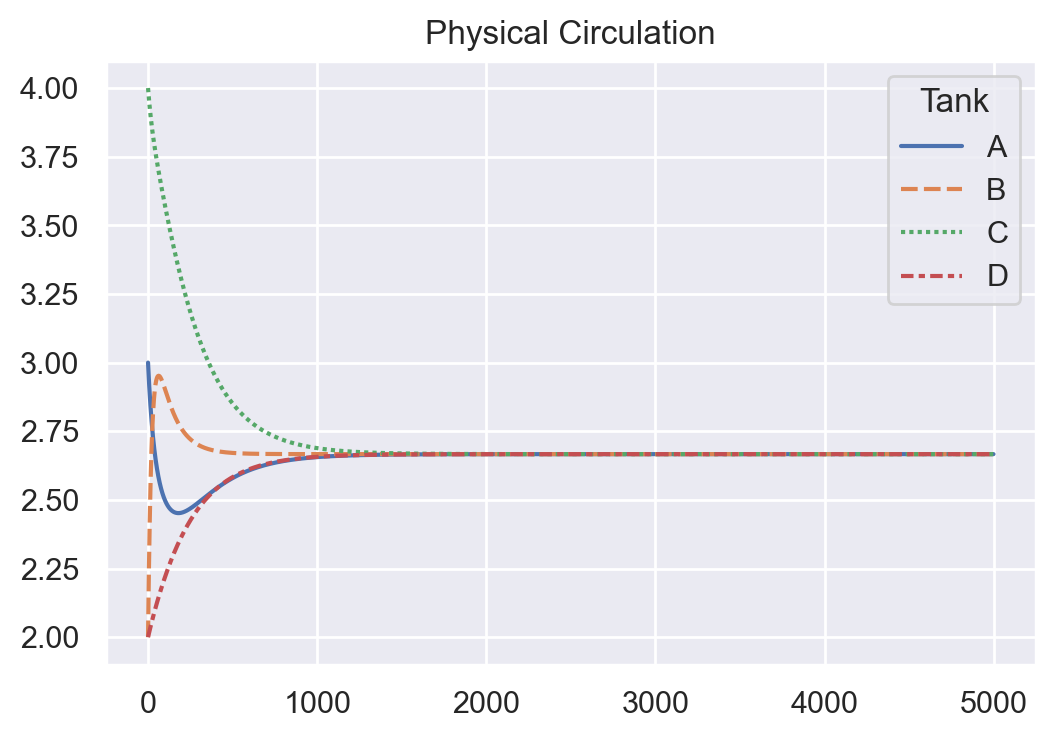

In [53]:
# volume
v = [600, 300, 3000, 6000] # L

# initial concentration [PO4]
P0 = [3, 2, 4, 2] # umol/L

# solve sys_abio with c = P0 and t = t (set to 5000 hrs at the very beginning)
sol_phys = odeint(sys_phys, P0, t)

# default plot settings
def legend():
    plt.legend(title="Tank", labels=("A","B","C","D"))

# plot
sns.lineplot(data=sol_phys).set(title="Physical Circulation")
legend()

# show final concentrations (roughly steady state)
print("[A, B, C, D] = ", sol_phys[-1])

Steady-state from the beginning: not a huge surprise when all the water has the same concentration. Adjust the initial conditions and run the model again. Get a sense for the model behavior before moving on.

## Incorporating Biogeochemistry

Now, we want to include biogeochemistry: the influence of life. Unlike physical circulation, we have some creative freedom in how we interpret and model biogeochemistry. Let's start with the basics, the aspects of our model where we have the most certainty. When surface algae incorporate phosphate into their tissues, the dissolved amount decreases in their surroundings. When they die and sink to the deep, heterotrophs consume them and remineralize their nutrients, _increasing_ the dissolved amount at depth. The net effect is a net downward nutrient flux. Let's consider how to incorporate this into our model. Just as we've seen before, any flux between tanks should be included as equal and opposite effects. Here, this means _whatever_ negative flux term is associated with a surface tank must be balanced by a positive term in the corresponding deep tank Let's add this process to our physical circulation model:
$$\mathbf{c}' = f(\mathbf{c}) = \boxed{\left(Q \mathbf{c} + \mathbf{b}\right)/\mathbf{v},}\qquad \mathbf{b} = \beta\cdot\begin{bmatrix}-A\\-B\\B\\A\end{bmatrix}$$
Remember, we haven't decided _exactly_ how we want to define $\mathbf{b}$ yet, but we are choosing to enforce a certain _structure._ In particular, we are saying that the nutrient flux from each surface reservoir is going to be proportional ($\beta$ is the proportionality constant) to _something_ in that reservoir. Whatever that something is, it has a value in A and B. And since each flux is headed straight downward, we know the first two terms should be negative and the second two should be the positive counterparts. Here it is in python:

In [54]:
# function to set structure of b
def bio(beta, A, B):
    return beta * np.array([-A, -B, B, A])

Keep in mind, we are trying to explain real patterns observed in the ocean. Namely, the surface is almost completely devoid of nutrients! So experiment with the models and try to replicate this condition. Now that we have a mathematic framework, let's get started with our first attempt to actually define the biogeochemical flux.

### Production Proportional to Surface Nutrient Amount

Here we assume $\mathbf{b}$ is proportional to the nutrient amount in the appropriate surface tank. In this case, $\beta$ is a rate constant.

[A, B, C, D] =  [1.55471425 1.36434109 2.00685059 3.17288623]


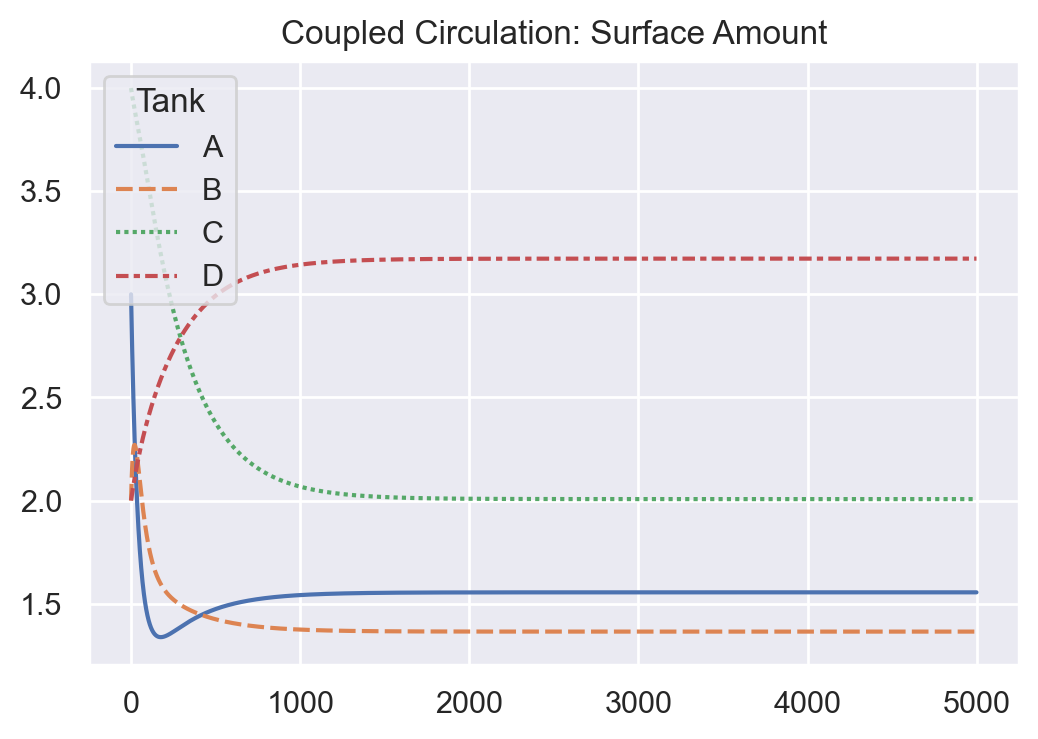

In [55]:
# defining combined phys. and biogeochem. system
# b is prop. to surface nutrient amounts (c * v)
# In the term "*(c * v)[:2]" the leading * means 
# two arguments (A and B) of bio(beta, A, B)
# [:2] means "the first two entries of (c * v)"
def sys_bio_amount(c, t):
    b = bio(rate_constant, *(c * v)[:2])
    return (Q @ c + b) / v

# rate constant: what fraction of the surface
# nutrient reservoir is transported each hr?
rate_constant = .01 # (/hr)

sol_amount = odeint(sys_bio_amount, P0, t)

sns.lineplot(data=sol_amount).set(title="Coupled Circulation: Surface Amount")
legend()

print("[A, B, C, D] = ", sol_amount[-1])

What $\beta$ values are necessary for both surface tanks to reach equilibrium essentially devoid of nutrient, e.g., less than 0.01 umol/L? Do the two deep tanks reach the same concentration? What about the surface?

### Biological Circulation Set by Surface Influx

Here we assume $\mathbf{b}$ is proportional to the nutrient influx in the appropriate surface tank.

[A, B, C, D] =  [1.57142856 1.04761905 2.09523812 3.14285713]
[[0 2 0 6]
 [8 0 4 0]]


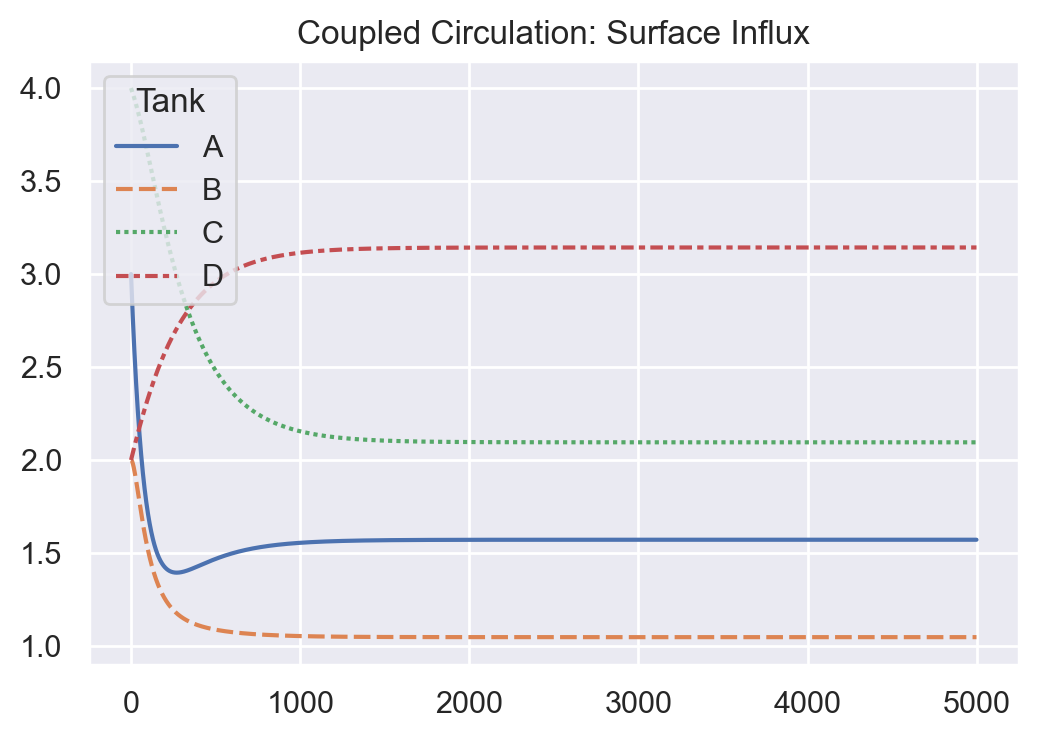

In [56]:
def sys_flux(c, t):
    b = bio(fraction, *(Qh @ c)[:2]) # remember Qh?
    return (Q @ c + b) / v

# fraction: what fraction of the surface nutrient 
# influx is diverted to depth?
fraction = .4

sol_flux = odeint(sys_flux, P0, t)

sns.lineplot(data=sol_flux).set(title="Coupled Circulation: Surface Influx")
legend()

print("[A, B, C, D] = ", sol_flux[-1])
print(Qh[:2])

Again, what $\beta$ values are necessary to reach near-zero surface concentrations? What similarities and differences do you notice between the two models?

## Oxygen: Circulation & Gas Exchange

Finally, we model oxygen, whose cycling is linked stoichiometrically to phosphate. Unlike phosphate, oxygen exchanges with the atmosphere at the surface. This process changes concentrations, not amounts, which we reflect in the placement of a new term term $\mathbf{r}$:
$$\mathbf{c}' = f(\mathbf{c}) = \boxed{\left(Q\mathbf{c} + \mathbf{b}\right)/\mathbf{v} + \mathbf{r}}$$
This system is combined with the previous one, since we still need to model phosphate:

[C, D] =  [269.08940677 158.93218614]


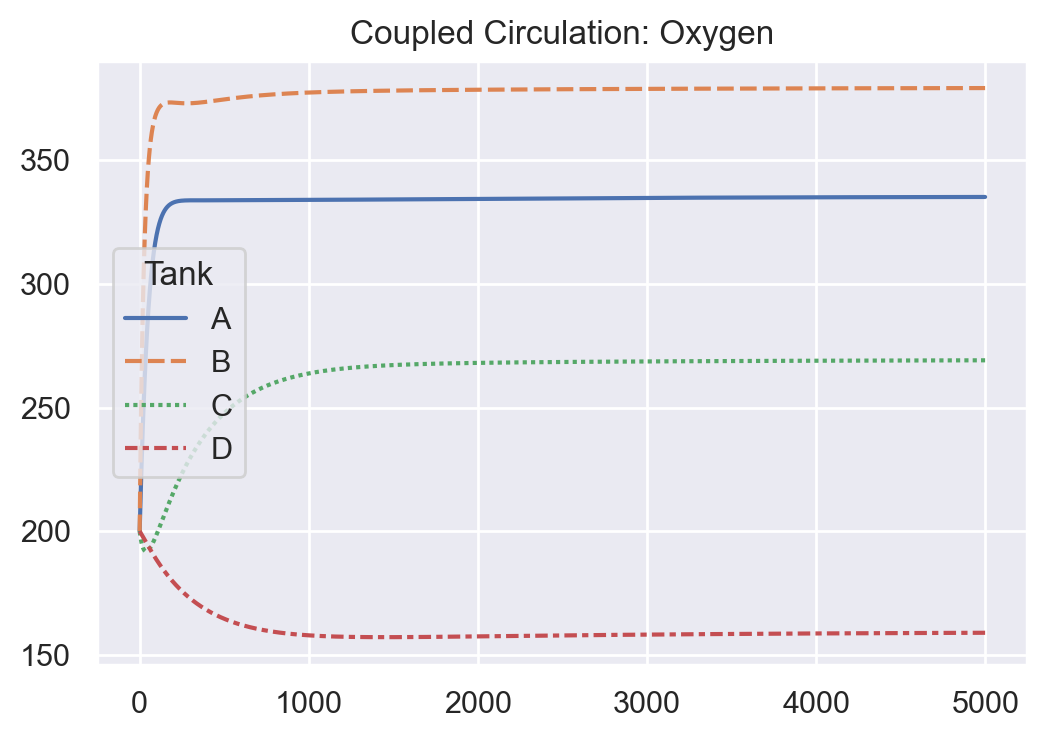

In [57]:
def sys_oxy(c, t):
    b = bio(beta_flux, *(Qh[:2] @ c[:4]))
    r = k_eq * np.array([c_eq - c[4], c_eq - c[5], 0, 0])
    return np.append((Q @ c[:4] + b) / v,
                     (Q @ c[4:] + R * b) / v + r)

R = -105 # Redfield ratio: O2:PO4 in photosynthesis
c_eq = 350 # surface [O2] at atmospheric equilibrium (umol/L)
k_eq = 0.01 # atmospheric equilibration rate constant (/hr)

O0 = [200, 200, 200, 200] # Initial [O2] (umol/L)

sol_oxy = odeint(sys_oxy, np.append(P0, O0), t)

sns.lineplot(data=sol_oxy[:,4:]).set(title="Coupled Circulation: Oxygen")
legend()

print("[C, D] = ", sol_oxy[-1,6:]) # deepwater oxygen concentrations

## Summary

To conclude the activity, write a brief summary essay answering the following questions:

For the physical circulation model, what factors influence the system's initial behavior and long term steady-state conditions? Be sure to interpret any differences you notice in the behavior of the four tanks.

Which definition of the biological flux do you think is a more accurate reflection of real ocean nutrient cycling? Under what spatial or temporal circumstances (if any) would you use these definitions?

Do some cursory research into broad nutrient and oxygen trends in the Atlantic and Pacific oceans. Can this model provide any insight into why these trends might occur?

Include at least three plots in your write-up with documentation of the relevant model assumptions, equations, etc.

BONUS: Explore and evaluate the following models, which duplicate the problem as it was originally posed by Broecker and Peng (1982). They key difference is that the system is not closed; there is an external pump continually supplying water _of a set concentration,_ along with a drain to balance the system. Originally, the flow rates associated with those external components were provided. However, it is possible to calculte what they need to be to maintain constant volume in each tank, given the hollow matrix of internal flow rates like we saw previously. (Find the one term which changed, and check what those external flow rates have to be using print(qe). You can confirm that they match the original problem statement.) What new behaviors do you notice? The first model is purely physical circulation, the second incorporates both a biological pump and oxygen circulation. What does this model capture about the real ocean that our closed system may have missed? Hint: you will need to adjust the time interval...

[A, B, C, D] =  [2.35810811 2.36896723 2.38778406 2.42088045]


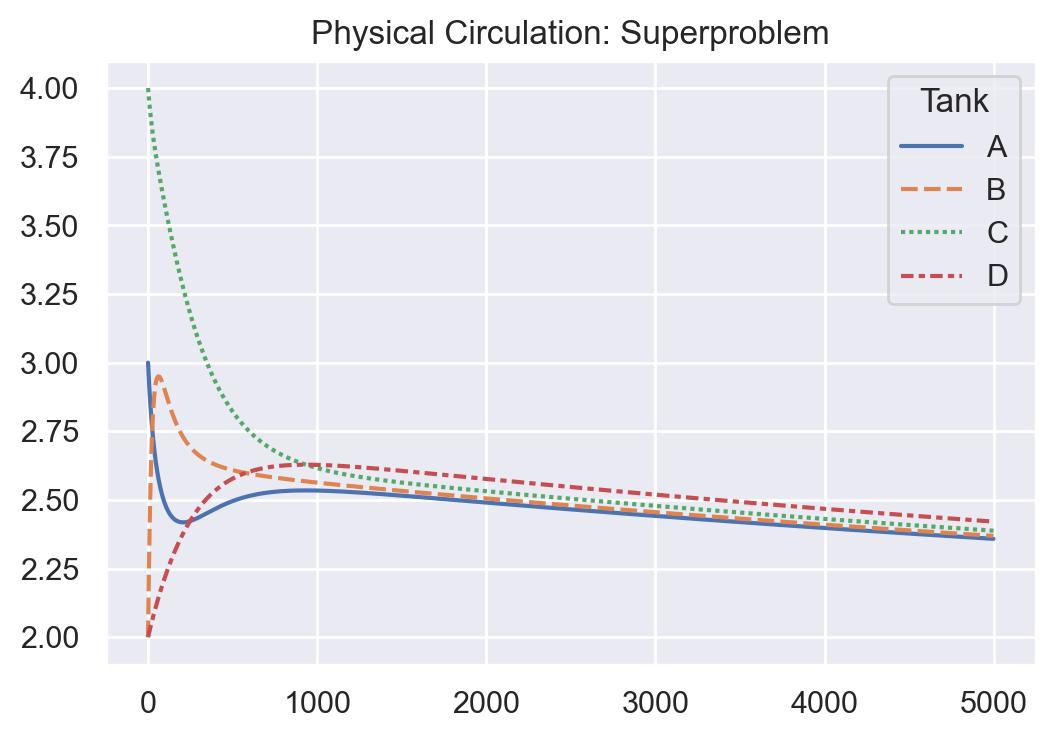

In [58]:
Qhs = np.array([[0,  2, 0, 5], # s for "superproblem" (L/hr)
                [8,  0, 4, 0],
                [0, 10, 0, 2],
                [0,  0, 8, 0]])

qe = Qhs.sum(axis = 0) - Qhs.sum(axis = 1) # external flow rates needed to maintain volume
qi, qo = np.mean([[qe, np.abs(qe)], [qe, -np.abs(qe)]], axis = 1)

Qs = Qhs - np.diag(Qhs.sum(axis = 0)) + np.diag(qo) # L/hr

ci = 2 # external inflow [PO4] (umol/L)

def sys_super(c, t):
    return (Qs @ c + qi * ci) / v

sol_super = odeint(sys_super, P0, t)

sns.lineplot(data=sol_super).set(title="Physical Circulation: Superproblem")
legend()

print("[A, B, C, D] = ", sol_super[-1])

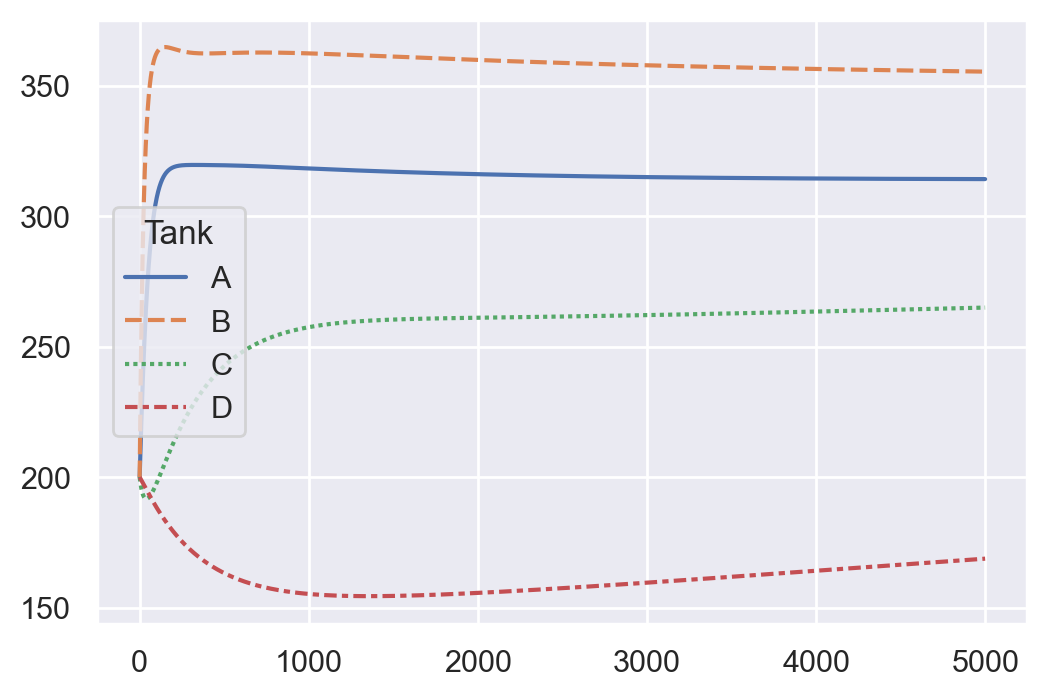

In [59]:
def sys_super_oxy(c, t):
    b = bio(beta_flux, *(Qh[:2] @ c[:4]))
    r = k_eq * np.array([c_eq - c[4], c_eq - c[5], 0, 0])
    return np.append((Qs @ c[:4] + qi * ci + b) / v,
                     (Qs @ c[4:] + qi * ci + R * b) / v + r)

sol_super_oxy = odeint(sys_super_oxy, np.append(P0, O0), t)

sol_super_oxy_title = "Coupled O$_2$ Superproblem: $\mathbf{b} \propto$Surface PO$_4^{3-}$ Influx"

sns.lineplot(data=sol_super_oxy[:,4:])
legend()

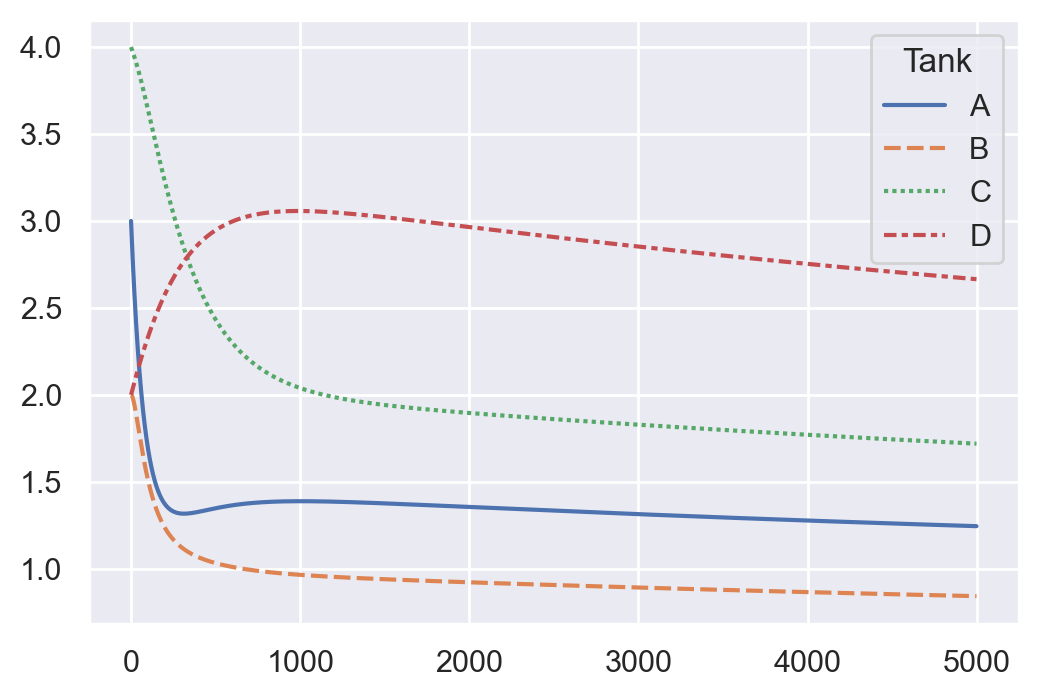

In [60]:
sns.lineplot(data=sol_super_oxy[:,:4])
legend()